In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model
from sklearn.cluster import OPTICS

2023-12-23 13:53:31.190953: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-23 13:53:31.191048: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-23 13:53:31.221323: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-23 13:53:31.273245: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-23 13:53:32.312750: W tensorflow/compiler/tf2

In [2]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()
#https://stackoverflow.com/questions/53171057/numpy-matrix-rotation-for-any-degrees
angles=4
train_limit=30000
x_train = (x_train.astype('float32') / 255.)[:train_limit]
x_test = x_test.astype('float32') / 255.

print (x_train.shape)
print (x_test.shape)

(30000, 28, 28)
(10000, 28, 28)


In [3]:
# Create an empty array to store the rotated matrices
rotated_train = np.empty_like(np.repeat(x_train,angles,axis=0))
static_train = np.empty_like(np.repeat(x_train,angles,axis=0))

for i in range(rotated_train.shape[0]):
    rotated_matrix = np.rot90(x_train[int(i//angles)], k=i%angles)  # k=1 for a 90-degree rotation
    rotated_train[i] = rotated_matrix
    static_train[i] = x_train[int(i//angles)]

        
# Create an empty array to store the rotated matrices
rotated_test = np.empty_like(np.repeat(x_test,angles,axis=0))
static_test = np.empty_like(np.repeat(x_test,angles,axis=0))

for i in range(rotated_test.shape[0]):
    rotated_matrix = np.rot90(x_test[int(i//angles)], k=i%angles)  # k=1 for a 90-degree rotation
    rotated_test[i] = rotated_matrix
    static_test[i] = x_test[int(i//angles)]


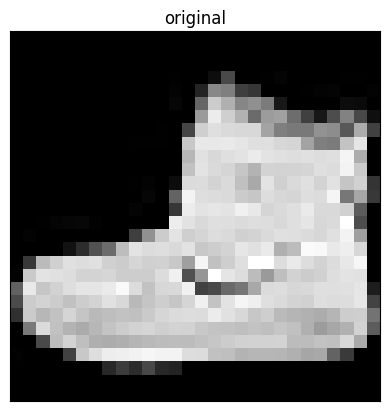

In [4]:
ax = plt.subplot()
plt.imshow(static_train[0])
plt.title("original")
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)



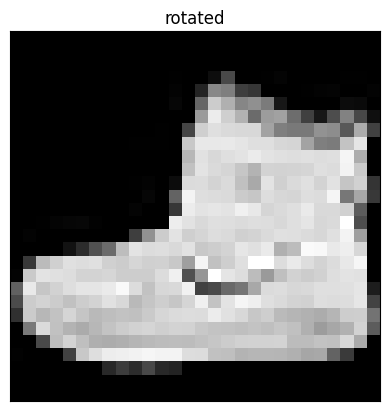

In [5]:
ax = plt.subplot()
plt.imshow(rotated_train[0])
plt.title("rotated")
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

In [6]:
train_transform = np.empty((static_train.shape[0], static_train.shape[1], static_train.shape[2], 3), dtype=float)
for i, matrix in enumerate(static_train):
    # Perform a 2D FFT on the matrix
    fft_result = np.fft.fft2(matrix)
    
    # Split the FFT result into real and imaginary parts
    magnitude = np.abs(fft_result)
    phase = np.angle(fft_result)
    
    # Store the real and imaginary parts in the result_array
    train_transform[i, :, :, 0] = matrix
    train_transform[i, :, :, 1] = magnitude
    train_transform[i, :, :, 2] = phase
print(train_transform.shape)

(120000, 28, 28, 3)


In [7]:
rot_train_transform = np.empty((rotated_train.shape[0], rotated_train.shape[1],rotated_train.shape[2], 3), dtype=float)
for i, matrix in enumerate(rotated_train):
    # Perform a 2D FFT on the matrix
    fft_result = np.fft.fft2(matrix)
    
    # Split the FFT result into real and imaginary parts
    magnitude = np.abs(fft_result)
    phase = np.angle(fft_result)
    
    # Store the real and imaginary parts in the result_array
    rot_train_transform[i, :, :, 0] = matrix
    rot_train_transform[i, :, :, 1] = magnitude
    rot_train_transform[i, :, :, 2] = phase
print(rot_train_transform.shape)

(120000, 28, 28, 3)


In [8]:
test_transform = np.empty((static_test.shape[0], static_test.shape[1],static_test.shape[2], 3), dtype=float)
for i, matrix in enumerate(static_test):
    # Perform a 2D FFT on the matrix
    fft_result = np.fft.fft2(matrix)
    
    # Split the FFT result into real and imaginary parts
    magnitude = np.abs(fft_result)
    phase = np.angle(fft_result)
    
    # Store the real and imaginary parts in the result_array
    test_transform[i, :, :, 0] = matrix
    test_transform[i, :, :, 1] = magnitude
    test_transform[i, :, :, 2] = phase
print(test_transform.shape)

(40000, 28, 28, 3)


In [9]:
rot_test_transform = np.empty((rotated_test.shape[0], rotated_test.shape[1],rotated_test.shape[2], 3), dtype=float)
for i, matrix in enumerate(rotated_test):
    # Perform a 2D FFT on the matrix
    fft_result = np.fft.fft2(matrix)
    
    # Split the FFT result into real and imaginary parts
    magnitude = np.abs(fft_result)
    phase = np.angle(fft_result)
    
    # Store the real and imaginary parts in the result_array
    rot_test_transform[i, :, :, 0] = matrix
    rot_test_transform[i, :, :, 1] = magnitude
    rot_test_transform[i, :, :, 2] = phase
print(rot_test_transform.shape)

(40000, 28, 28, 3)


In [10]:
class Autoencoder(Model):
    def __init__(self, latent_dim, shape):
        super(Autoencoder, self).__init__()
        self.latent_dim = latent_dim
        self.shape = shape
        self.encoder = tf.keras.Sequential([
          layers.Input(shape=(28, 28, 3)),
          layers.Conv2D(32, (3, 3), activation='relu', padding='same', strides=2),
          layers.Conv2D(32, (3, 3), activation='relu', padding='same', strides=2),
          layers.Flatten(),
          layers.Dense(32, activation='relu'),
          layers.Dense(16, activation='relu'),
          layers.Dense(8, activation='relu'),
        ])
        self.decoder = tf.keras.Sequential([
          layers.Dense(16, activation='relu'),
          layers.Dense(32, activation='relu'),
          layers.Dense(tf.math.reduce_prod(shape), activation='sigmoid'),
          layers.Reshape(shape)
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
    def reduced(self,x):
        return self.encoder(x)
    
shape = train_transform.shape[1:]
print(shape)
latent_dim = 64
autoencoder = Autoencoder(latent_dim, shape)

(28, 28, 3)


2023-12-23 13:53:57.896058: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-23 13:53:58.009203: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-23 13:53:58.009543: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [11]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredLogarithmicError(),metrics=['accuracy'])

In [12]:
autoencoder.fit(rot_train_transform, train_transform,
                epochs=10,
                shuffle=True,
                validation_data=(rot_test_transform, test_transform))

2023-12-23 13:54:01.762595: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1128960000 exceeds 10% of free system memory.
2023-12-23 13:54:04.487632: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1128960000 exceeds 10% of free system memory.
2023-12-23 13:54:06.572552: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1128960000 exceeds 10% of free system memory.
2023-12-23 13:54:07.286346: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1128960000 exceeds 10% of free system memory.


Epoch 1/10


2023-12-23 13:54:11.803613: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2023-12-23 13:54:14.825835: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fa8c7fafe60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-23 13:54:14.825873: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1070, Compute Capability 6.1
2023-12-23 13:54:14.843865: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1703361255.028395    4876 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


3745/3750 [============================>.] - ETA: 0s - loss: 0.3753 - accuracy: 0.7818

2023-12-23 13:54:47.168740: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 376320000 exceeds 10% of free system memory.


3750/3750 [==============================] - 45s 10ms/step - loss: 0.3753 - accuracy: 0.7818 - val_loss: 0.3720 - val_accuracy: 0.7839
Epoch 2/10
3750/3750 [==============================] - 32s 8ms/step - loss: 0.3708 - accuracy: 0.7842 - val_loss: 0.3704 - val_accuracy: 0.7845
Epoch 3/10
3750/3750 [==============================] - 32s 8ms/step - loss: 0.3696 - accuracy: 0.7843 - val_loss: 0.3696 - val_accuracy: 0.7849
Epoch 4/10
3750/3750 [==============================] - 32s 9ms/step - loss: 0.3688 - accuracy: 0.7850 - val_loss: 0.3691 - val_accuracy: 0.7856
Epoch 5/10
3750/3750 [==============================] - 31s 8ms/step - loss: 0.3683 - accuracy: 0.7858 - val_loss: 0.3686 - val_accuracy: 0.7860
Epoch 6/10
3750/3750 [==============================] - 32s 8ms/step - loss: 0.3680 - accuracy: 0.7862 - val_loss: 0.3684 - val_accuracy: 0.7865
Epoch 7/10
3750/3750 [==============================] - 32s 8ms/step - loss: 0.3678 - accuracy: 0.7864 - val_loss: 0.3683 - val_accuracy: 0.

In [13]:
encoded_imgs = autoencoder.encoder(rot_test_transform[:12]).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()
print(decoded_imgs.shape)

(12, 28, 28, 3)


In [14]:
first_image = decoded_imgs[..., 0]

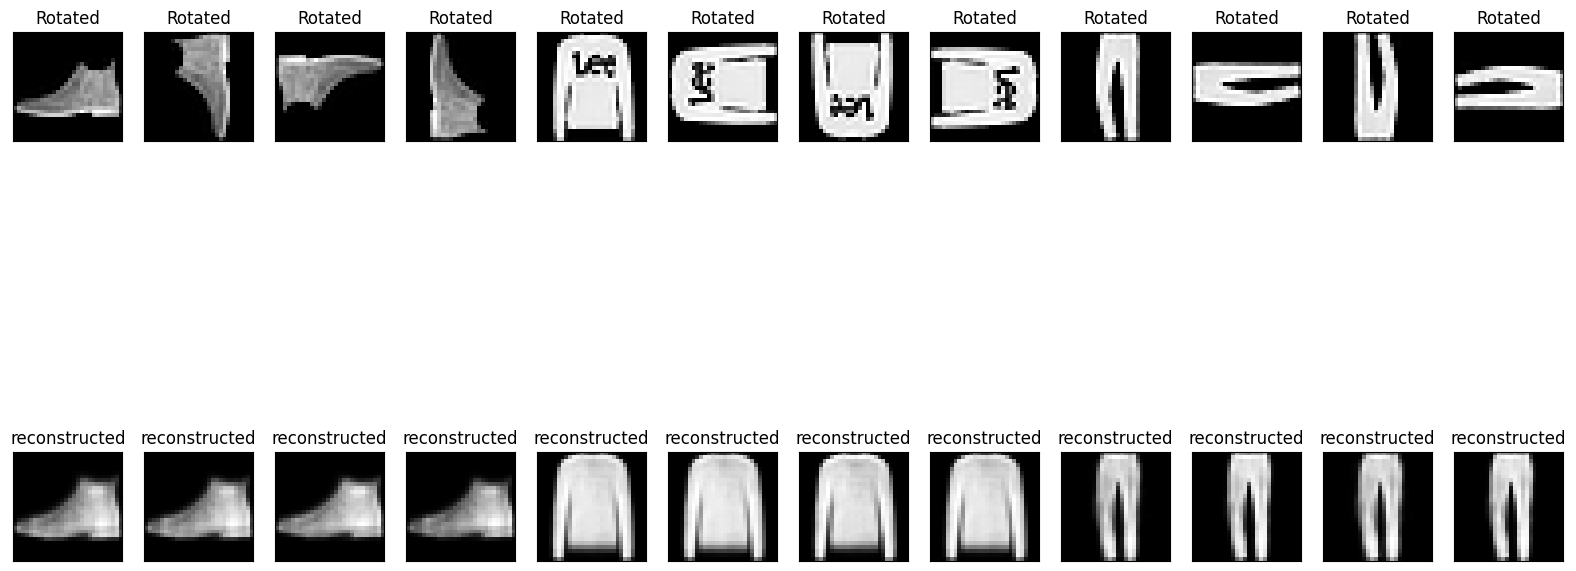

In [15]:
n = 12
plt.figure(figsize=(20, 10))
for i in range(n):

    # display original + noise
    ax = plt.subplot(2, n, i + 1)
    plt.title("Rotated")
    plt.imshow(tf.squeeze(rotated_test[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    bx = plt.subplot(2, n, i + n + 1)
    plt.title("reconstructed")
    plt.imshow(tf.squeeze(first_image[i]))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
plt.show()